In [1]:
import h5py
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.nn as nn
import torch
import umap
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sample from Train Data
It's necessary to take a sample here, because there is so much data. Even sampling just 50 individual time series, we end up with nearly 500 rows of data.  

In [2]:
def sample_from_index(hdf5_file, index_file, num_series=5):
    """
    Samples full time series from an HDF5 file using precomputed indices in an index CSV.

    Parameters:
        hdf5_file (str): Path to the main dataset HDF5 file.
        index_file (str): Path to the CSV index file storing time series indices.
        num_series (int): Number of full time series to sample.

    Returns:
        sampled_X (np.array): Sampled feature data.
        sampled_y (np.array): Corresponding labels.
    """
    index_df = pd.read_csv(index_file)

    # randomly sample num_series time series
    num_series = min(num_series, len(index_df))
    sampled_series = index_df.sample(num_series).sort_values(by=["start_idx"])

    sampled_rows = []
    for _, row in sampled_series.iterrows():
        sampled_rows.extend(range(row["start_idx"], row["stop_idx"] + 1))

    # load only the required rows
    with h5py.File(hdf5_file, "r") as infile:
        columns = [col.decode("utf-8") for col in infile.attrs["columns"]]
        sampled_X = infile["X"][sampled_rows]
        sampled_y = infile["y"][sampled_rows]

    print(f"Sampled {len(sampled_X)} rows covering {num_series} full time series.")
    return sampled_X, sampled_y, columns


In [6]:
y = y.reshape((y.shape[0], 1))
df = pd.DataFrame(np.concatenate((X, y), axis=1), columns=cols+["RUL"])
df.head()

,alt,Mach,TRA,T2,T24,T30,T48,T50,P15,P2,...,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,unit,cycle,Fc,hs,RUL
0,3003.0,0.360045,80.858803,521.126221,627.025269,1508.673950,1927.505859,1307.765259,19.915327,14.369046,...,0.0,-0.001596,0.0,0.0,0.0,4.0,48.0,1.0,0.0,47.0
1,3011.0,0.360927,80.858803,521.165771,627.102173,1508.770508,1927.294067,1307.453369,19.920103,14.371551,...,0.0,-0.001596,0.0,0.0,0.0,4.0,48.0,1.0,0.0,47.0
2,3022.0,0.361746,80.858803,521.183472,627.116882,1508.751221,1927.250244,1307.372437,19.919161,14.371414,...,0.0,-0.001596,0.0,0.0,0.0,4.0,48.0,1.0,0.0,47.0
3,3025.0,0.360423,80.858803,521.079773,627.017944,1508.575928,1926.920776,1307.163452,19.906031,14.360716,...,0.0,-0.001596,0.0,0.0,0.0,4.0,48.0,1.0,0.0,47.0
4,3040.0,0.363132,80.858803,521.221802,627.130737,1508.721069,1927.324341,1307.397217,19.918022,14.372139,...,0.0,-0.001596,0.0,0.0,0.0,4.0,48.0,1.0,0.0,47.0


In [12]:
one_cycle = df[(df['unit'] == 4.0) & (df['cycle'] == 48)]
print('Number of Records for one cycle: ', len(one_cycle))

Number of Records for one cycle:  3504


In [15]:
def plot_df_single_color(data, variables, labels, size=12, labelsize=17, name=None):
    """
    Plot the trends in different features over the course of one cycle
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)    
    fig  = plt.figure(figsize=(size,max(size,rows*2))) 
    
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        ax.plot(data[variables[n]], marker='.', markerfacecolor='none', alpha = 0.7)
        ax.tick_params(axis='x', labelsize=labelsize)
        ax.tick_params(axis='y', labelsize=labelsize)
        plt.ylabel(labels[n], fontsize=labelsize)
        plt.xlabel('Time [s]', fontsize=labelsize)
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

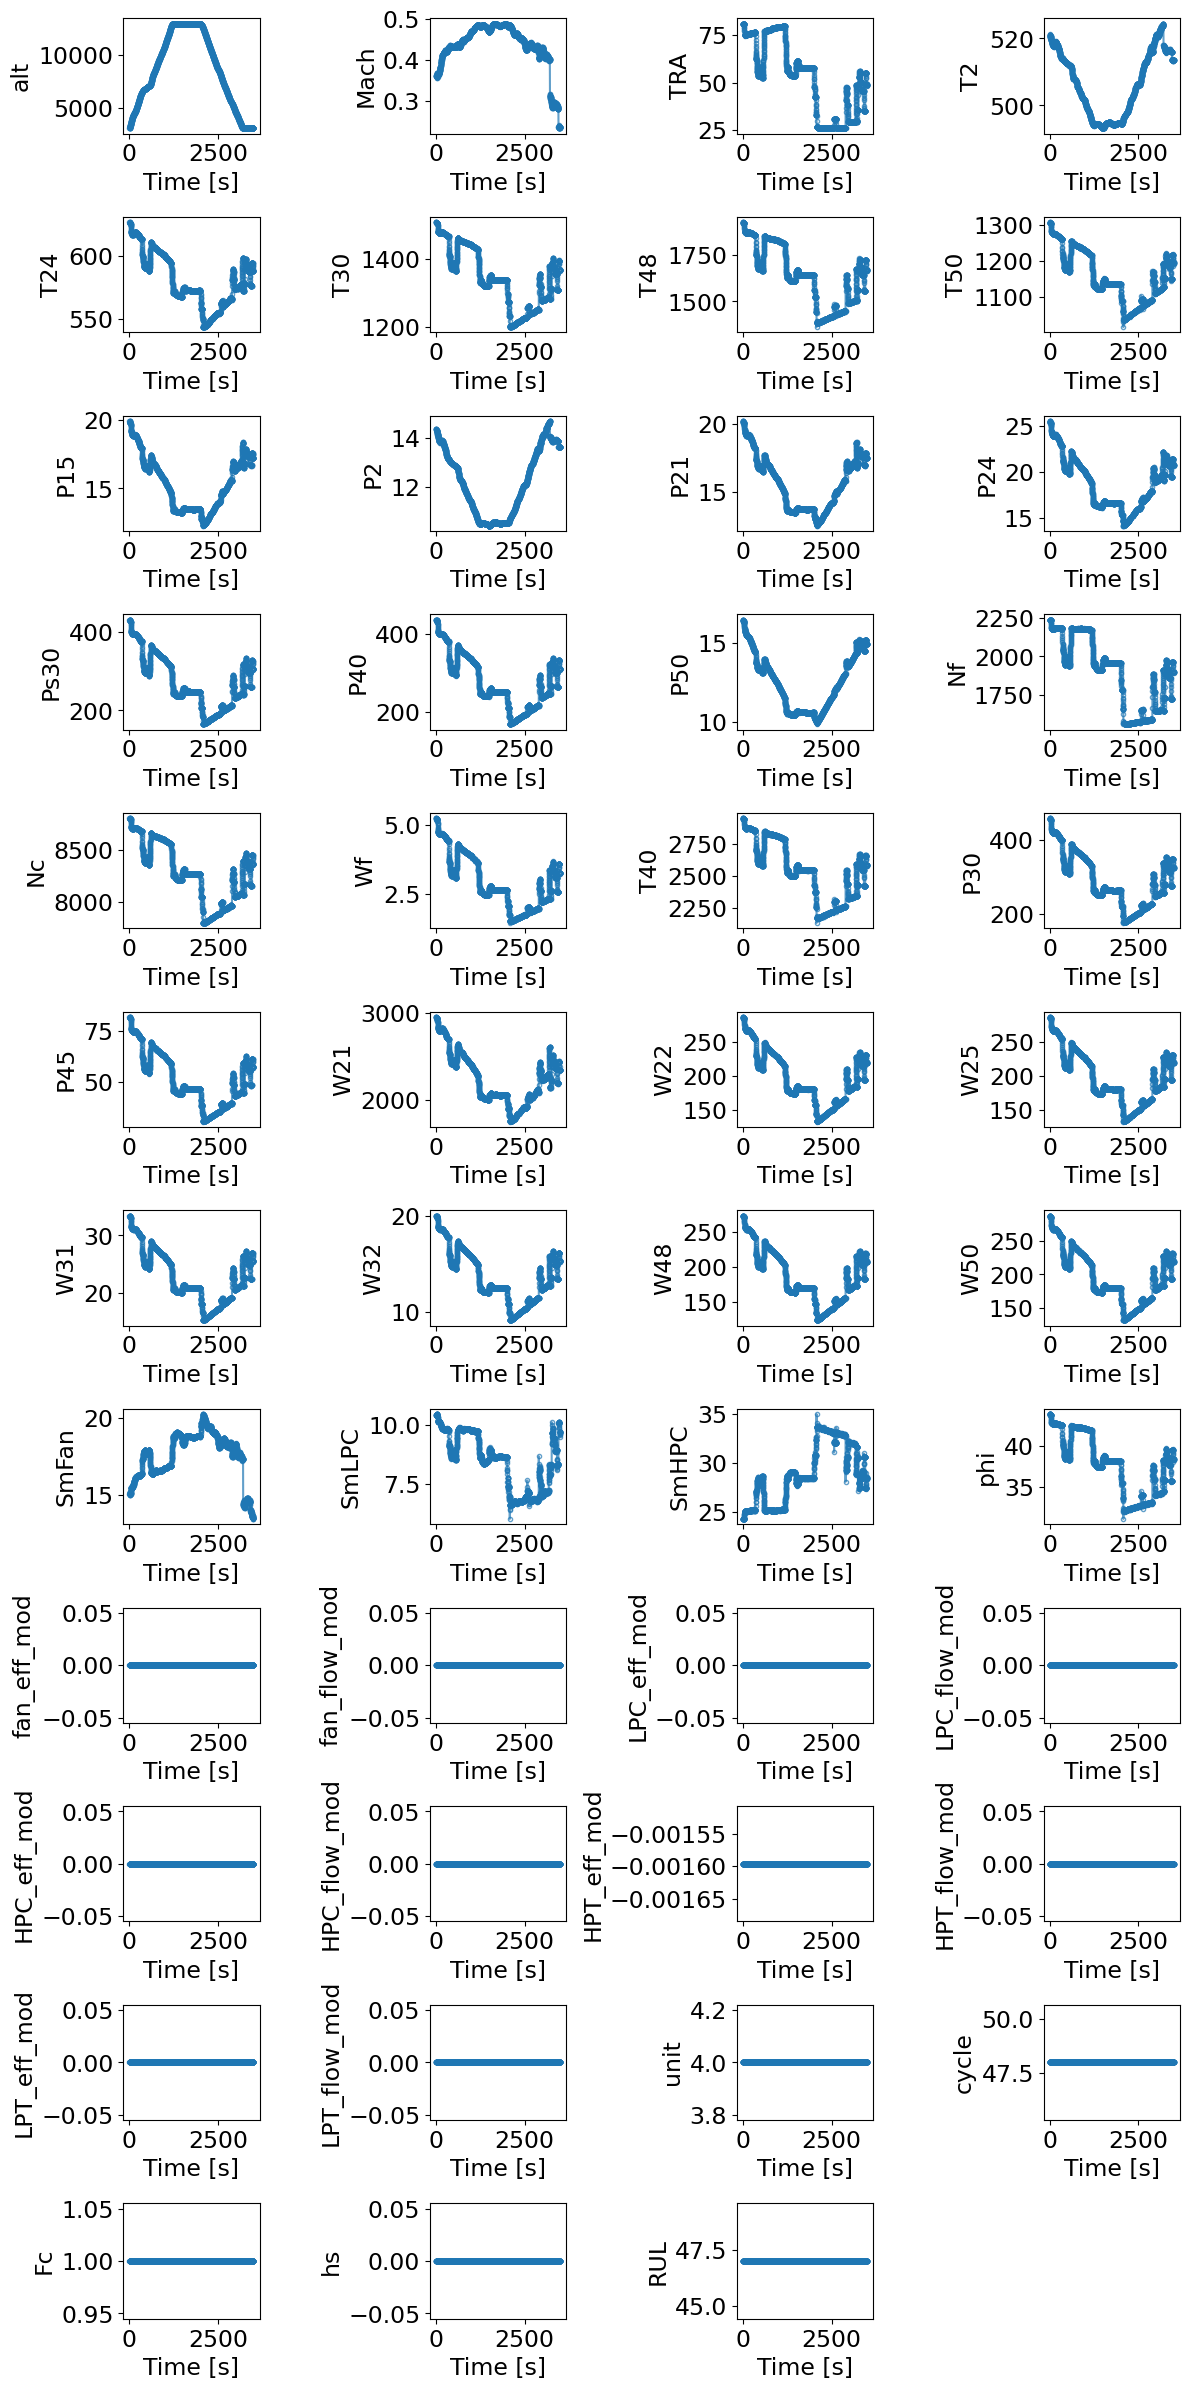

In [16]:
plotting_vars = list(one_cycle.columns)
    
one_cycle.reset_index(inplace=True, drop=True)
plot_df_single_color(one_cycle, plotting_vars, plotting_vars)

In [21]:
def plot_kde(leg, variables, labels, size, units, df_W, df_A, labelsize=17, name=None):
    """
    """
    plt.clf()
       
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs = gridspec.GridSpec(rows, cols)
    
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    fig = plt.figure(figsize=(size,max(size,rows*2)))       

    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for k, elem in enumerate(units):
            sns.kdeplot(df_W.loc[df_A['unit'] == elem, variables[n]],
                        color=color_dic_unit[leg[k]], shade=True, gridsize=20)  
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
        
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))        
        plt.xlabel(labels[n], fontsize=labelsize)
        plt.ylabel('Density [-]', fontsize=labelsize)
        if n==0:
            plt.legend(leg, fontsize=labelsize-4, loc=0)
        else:
            plt.legend(leg, fontsize=labelsize-4, loc=2)
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)    
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

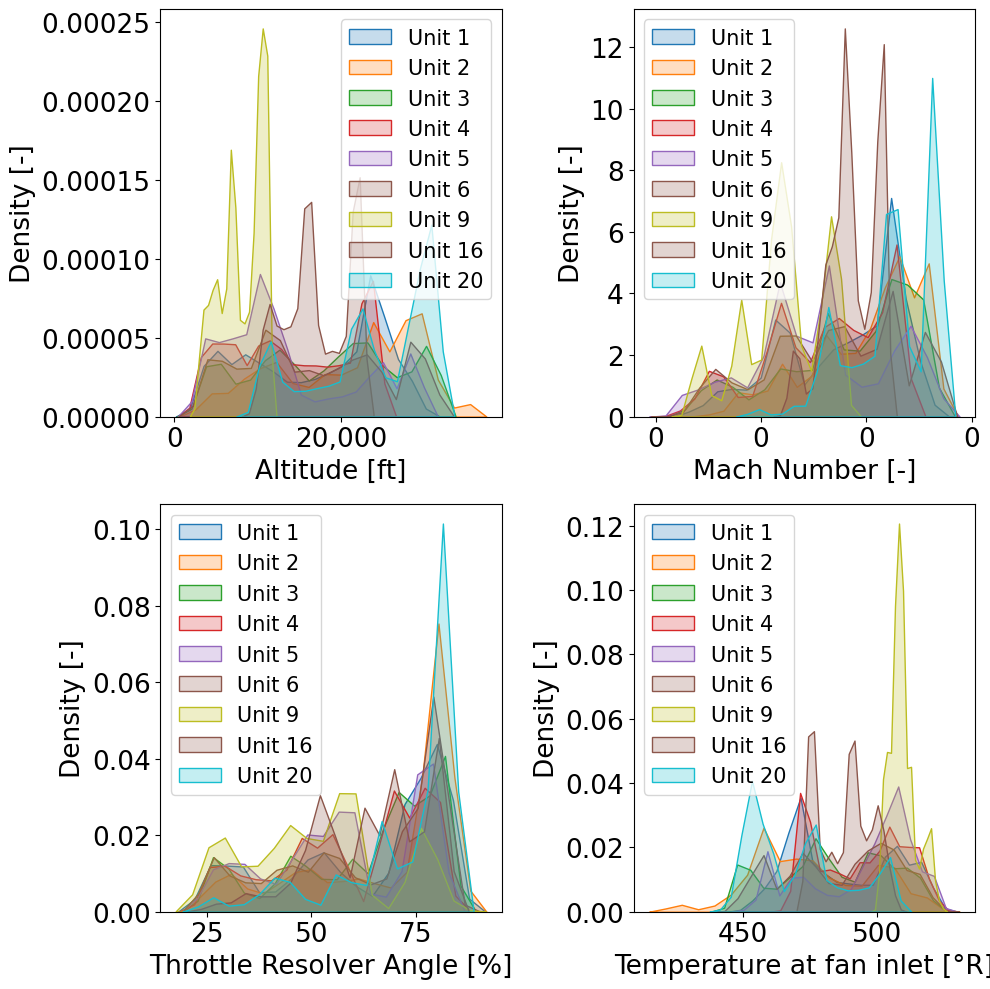

In [23]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

units = list(np.unique(df['unit']))
leg = ['Unit ' + str(int(u)) for u in units]

plot_kde(leg, variables, labels, size, units, df[['alt', 'Mach', 'TRA', 'T2']], df[['unit', 'cycle', 'Fc', 'hs', 'RUL']], labelsize=19, name='kde_DS02.png')

In [24]:
def create_time_windows(df, window_size=50, feature_cols=None, target_col="RUL", id_cols=["unit"]):
    if feature_cols is None:
        feature_cols = [col for col in df.columns if col not in id_cols + ["time", target_col]]

    X, y = [], []
    
    # Group by the identifier columns to ensure windows do not span multiple time series
    grouped = df.groupby(id_cols).size().reset_index().rename(columns={0:'count'})
    
    # for each time series
    for i in range(len(grouped)):
        subset = df
        for col in id_cols:
            subset = subset[subset[col] == grouped[col][i]]
        # for each window within the series (should be # obsvervations - window size for each series)
        for i in range(len(subset) - window_size):
            X.append(subset.iloc[i:i+window_size][feature_cols].values)
            y.append(subset.iloc[i+window_size][target_col])

    return np.array(X), np.array(y)


def save_to_hdf5(X, y, filename="data.h5"):
    with h5py.File(filename, "w") as f:
        f.create_dataset("X", data=X, compression="gzip")
        f.create_dataset("y", data=y, compression="gzip")

def load_from_hdf5(filename="data.h5"):
    with h5py.File(filename, "r") as f:
        X = f["X"][:]
        y = f["y"][:]
    return X, y


In [67]:
feature_cols = [col for col in df.columns if col not in ["unit", "cycle"] + ["time", 'RUL']]
feature_cols[0]

'alt'

In [26]:
# X, y = create_time_windows(df, window_size=50, target_col="RUL", id_cols=["unit", "cycle"])

In [27]:
# save_to_hdf5(X, y, "sample_windows.h5")

In [41]:
X, y = load_from_hdf5(filename="sample_windows.h5")

## Mean, SD, Min/Max, Range

In [59]:
# Compute per-window statistics across the time dimension (axis=1)
mean_values = np.mean(X, axis=1)  # Shape: (487592, 44)
std_values = np.std(X, axis=1)
min_values = np.min(X, axis=1)
max_values = np.max(X, axis=1)
range_values = max_values - min_values

# Combine into a single feature matrix
basic_features = np.hstack([mean_values, std_values, min_values, max_values, range_values])
print("Basic Features Shape:", basic_features.shape)  # (487592, 220)

Basic Features Shape: (487592, 220)


In [82]:
def plot_mean_windows(feature_cols):
    
    for i in range(len(feature_cols)):
    
        mean_values_alt = mean_values[:, i]

        # Plot distribution
        plt.figure(figsize=(8, 5))
        sns.histplot(mean_values_alt, bins=30, kde=True, color='blue', edgecolor='black')

        # Labels and title
        x_label = 'mean ' + str(feature_cols[i])
        plt.xlabel(x_label)
        plt.ylabel('Frequency')
        plt.title('Distribution of Prediction Variable')

        # Show plot
        plt.show()

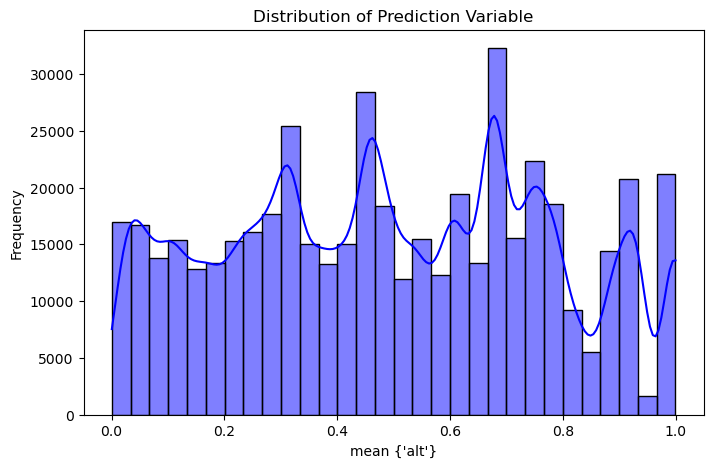

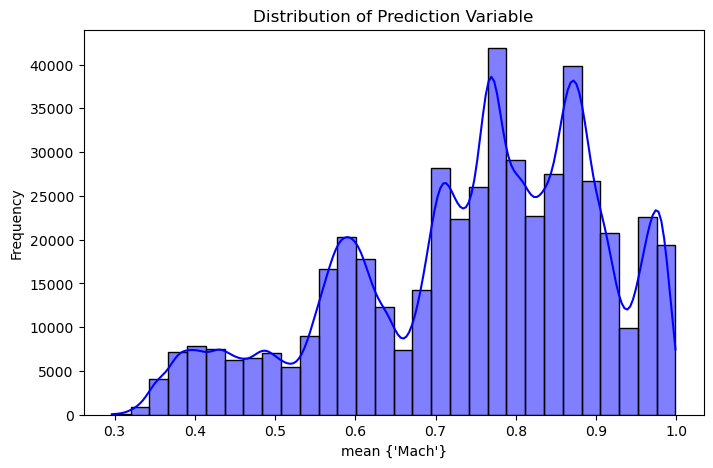

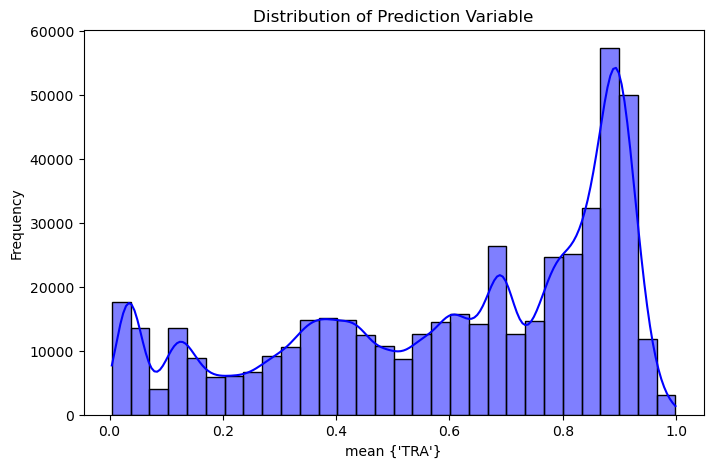

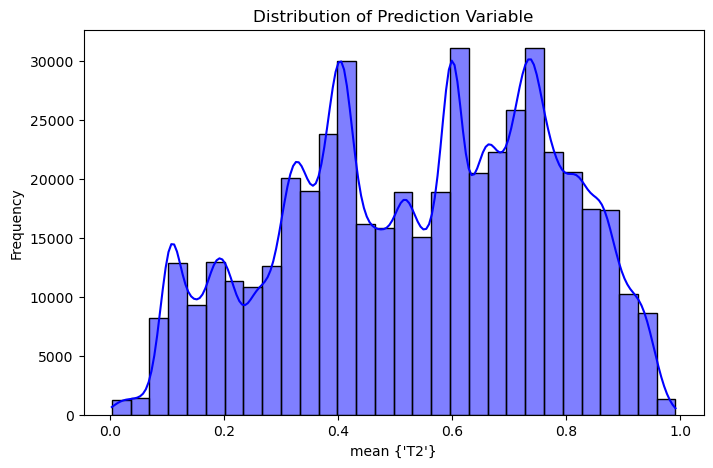

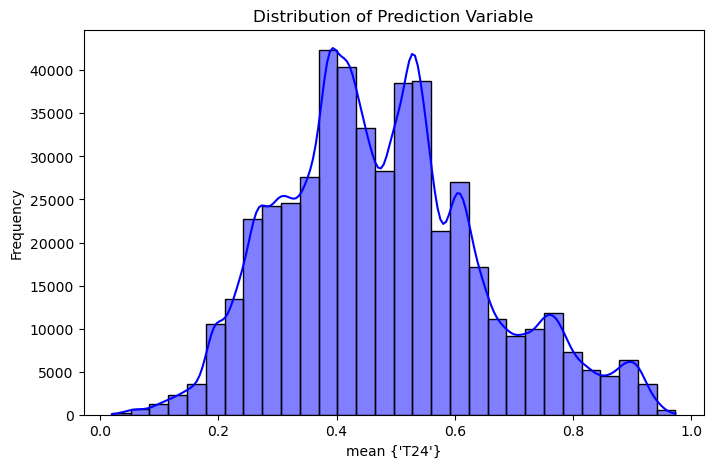

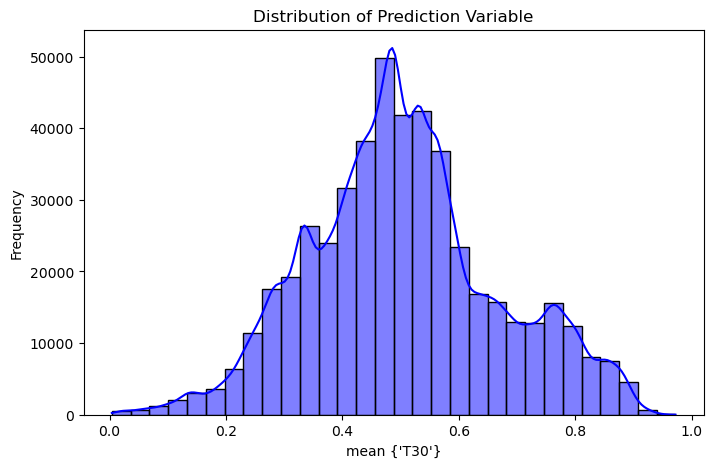

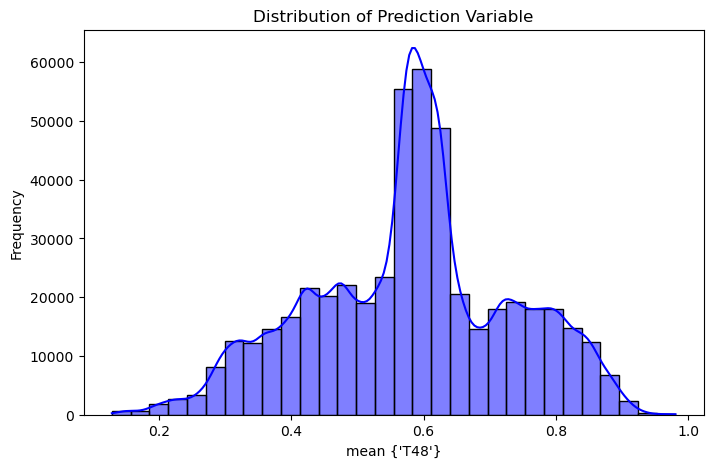

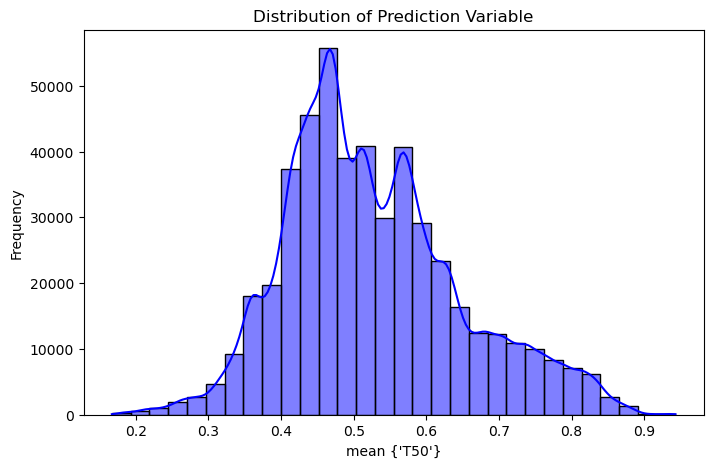

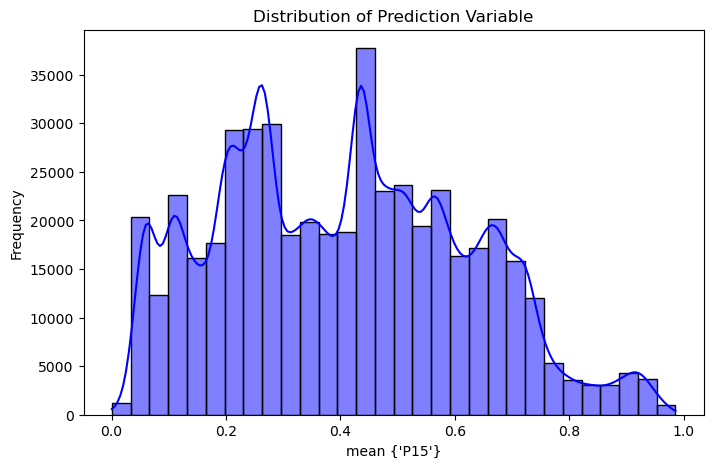

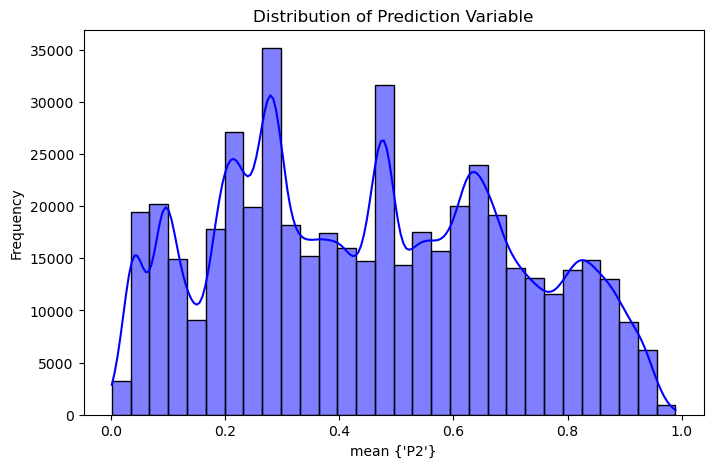

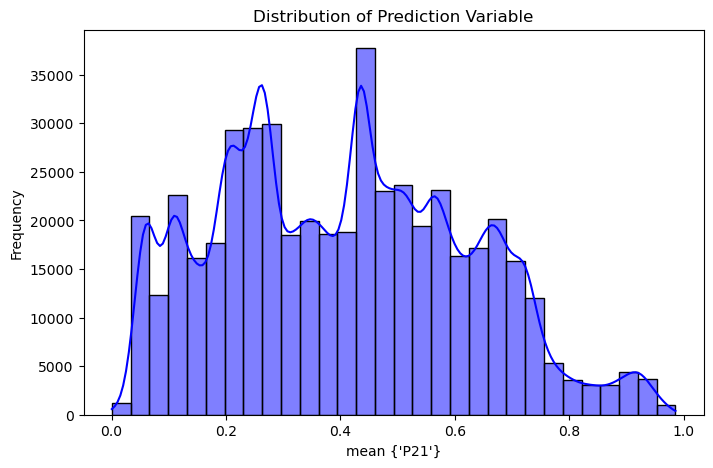

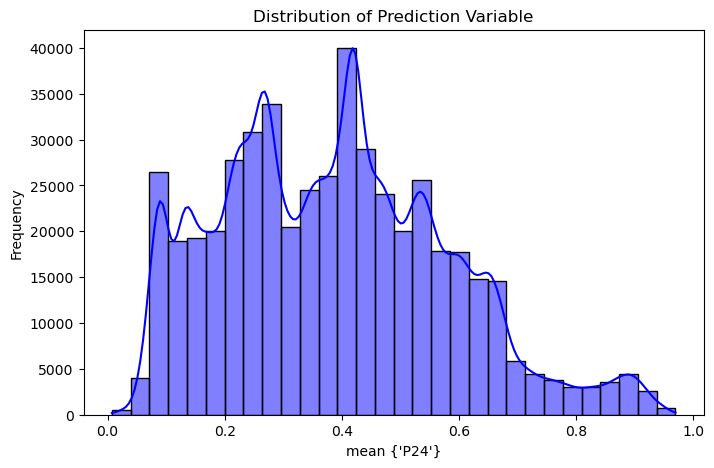

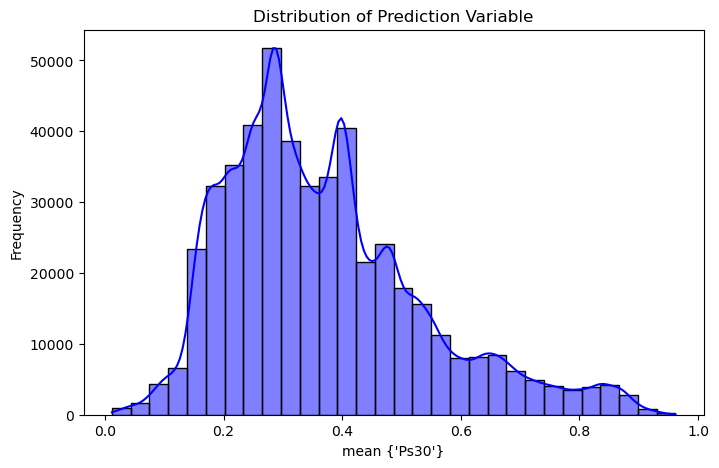

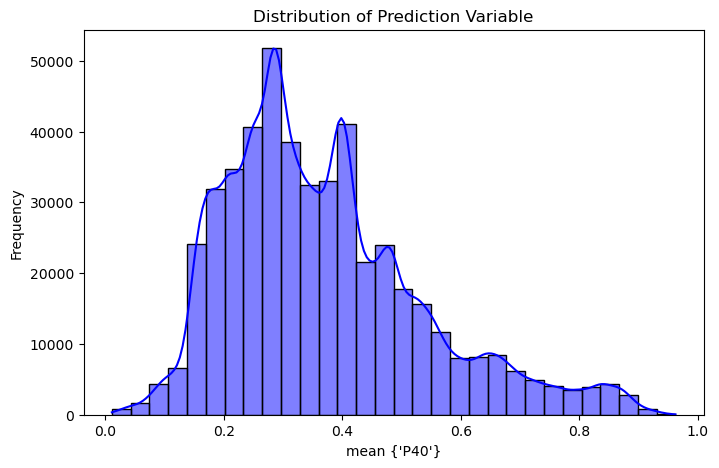

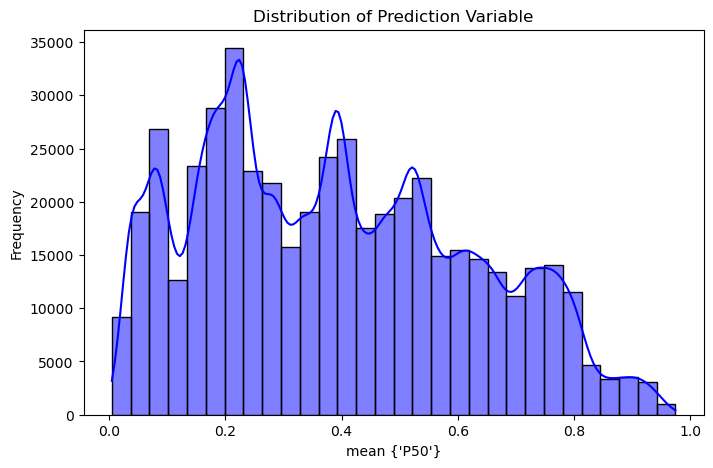

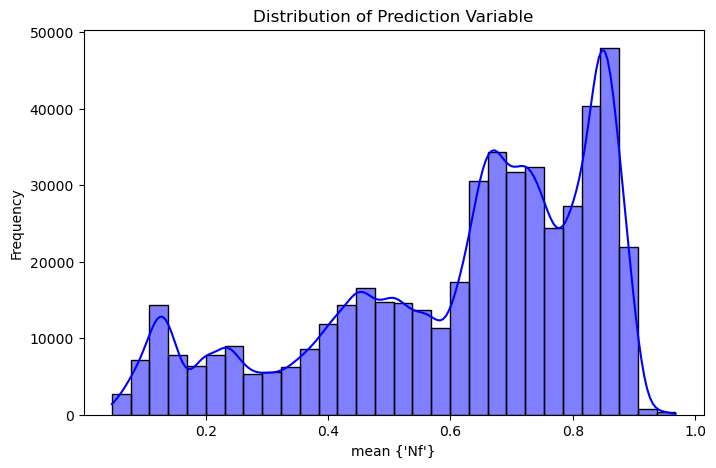

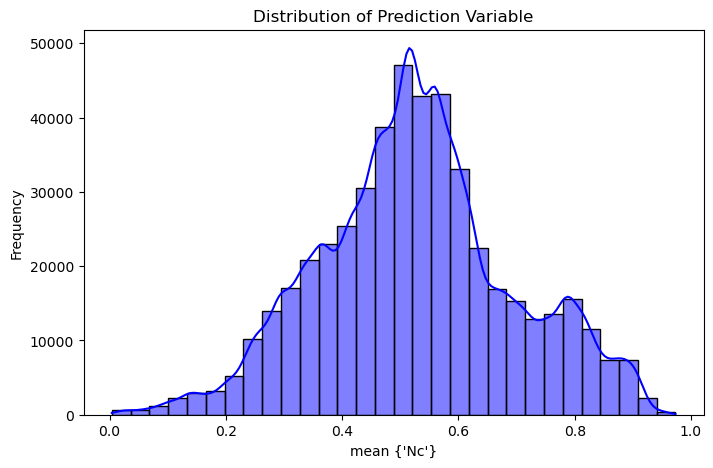

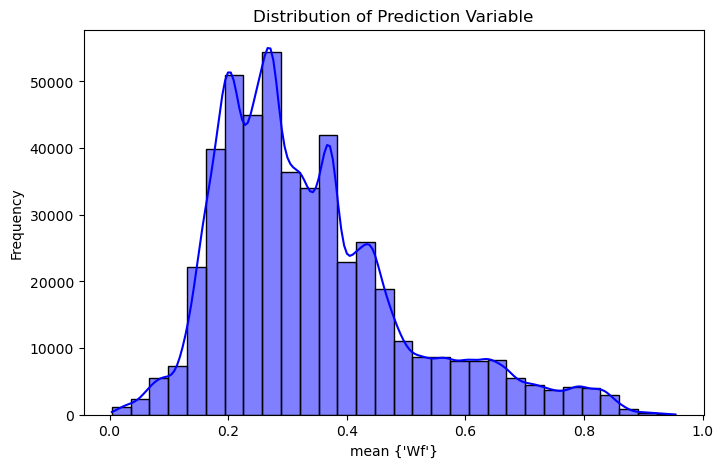

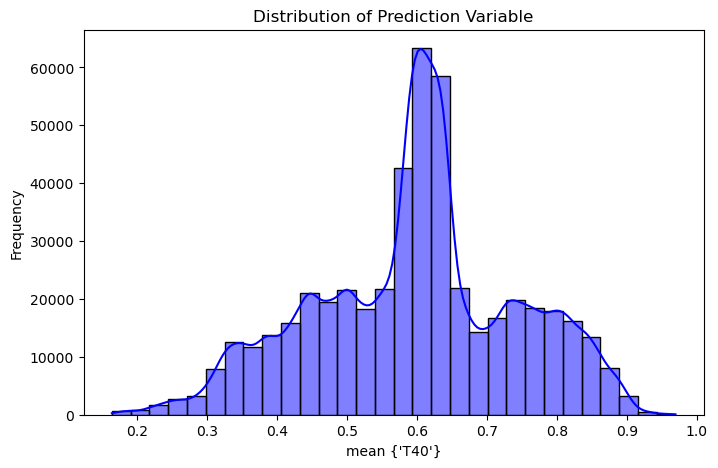

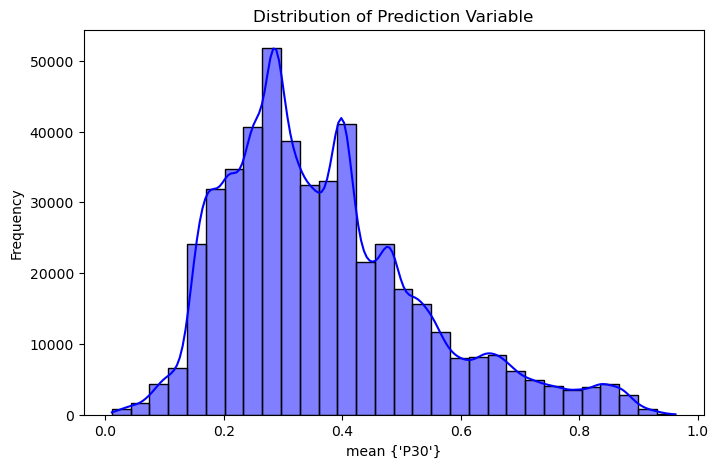

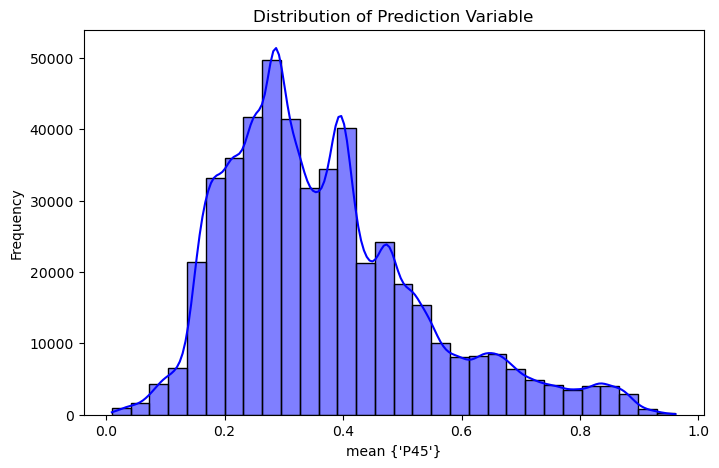

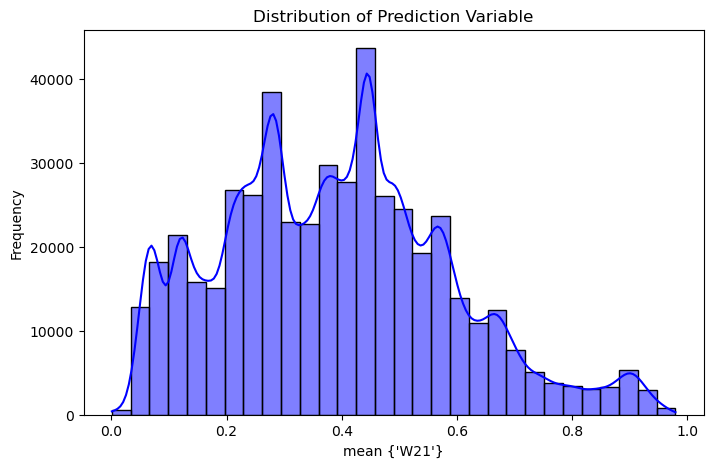

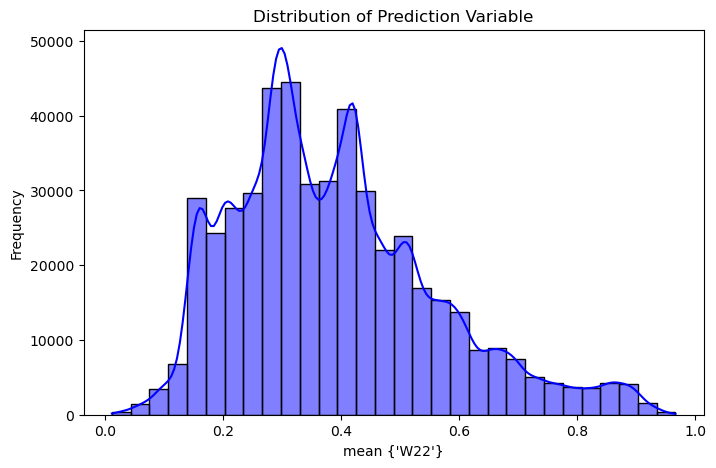

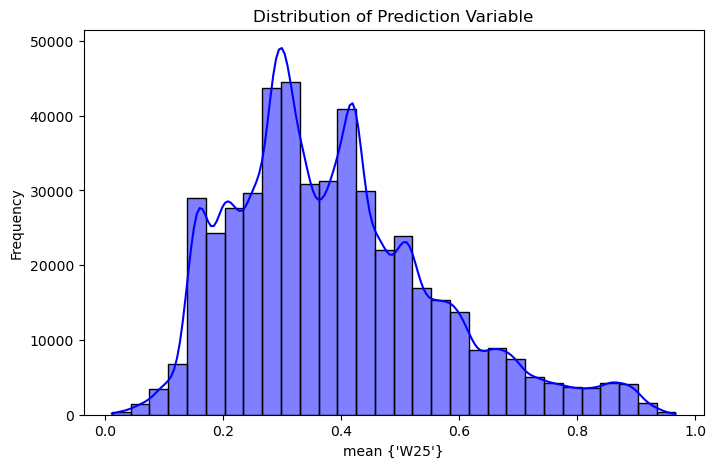

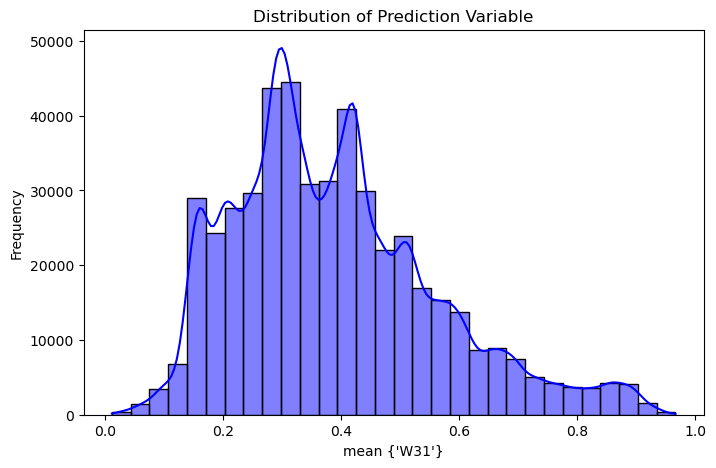

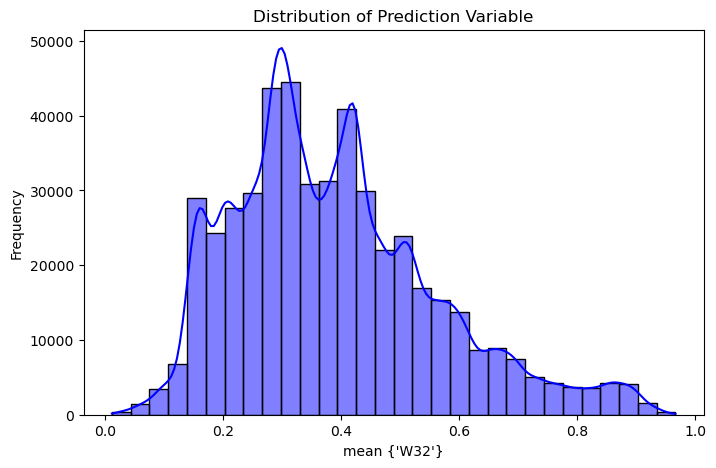

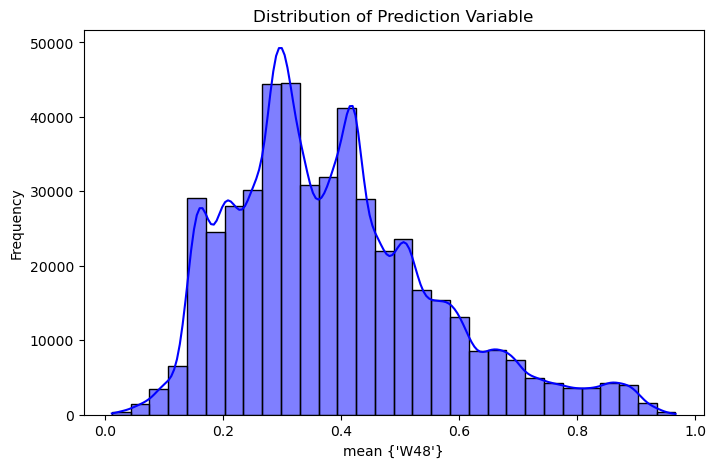

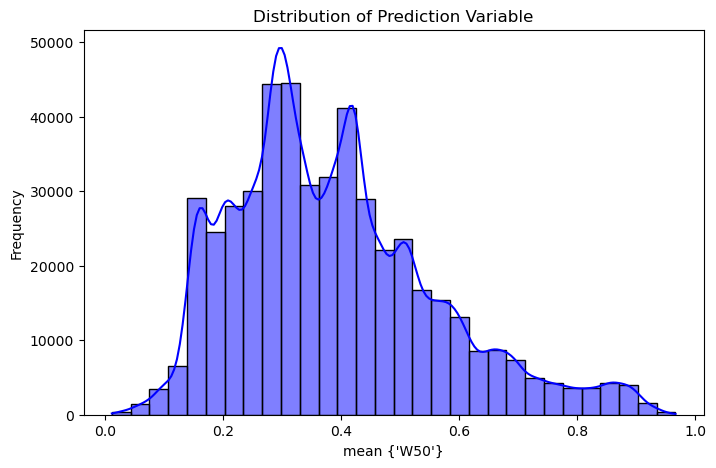

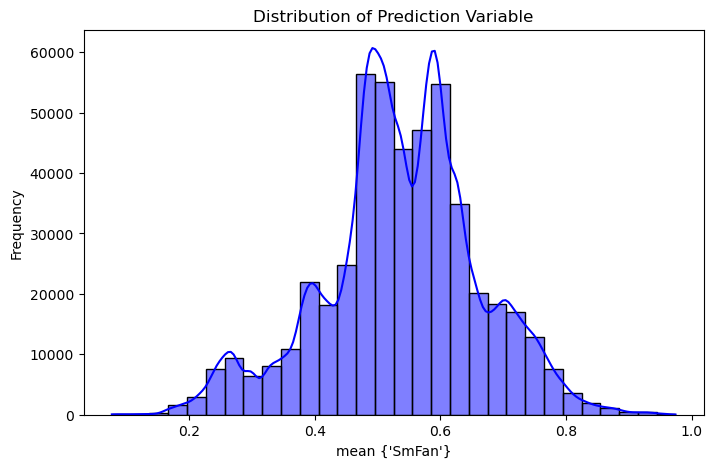

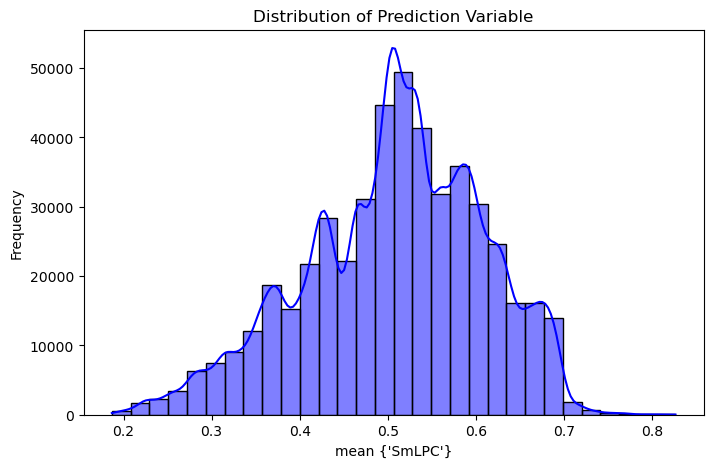

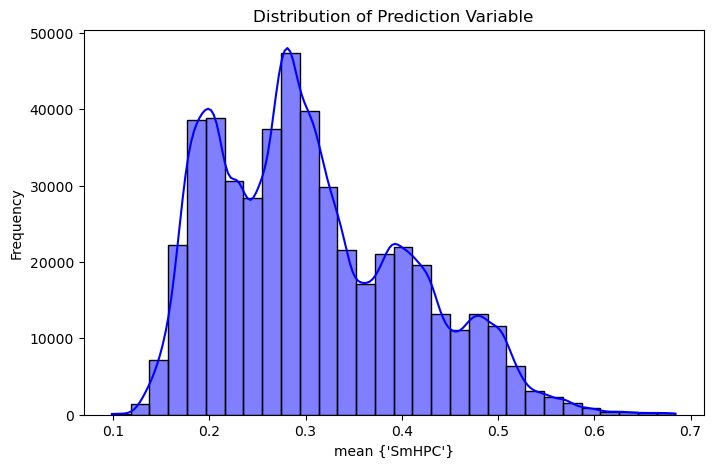

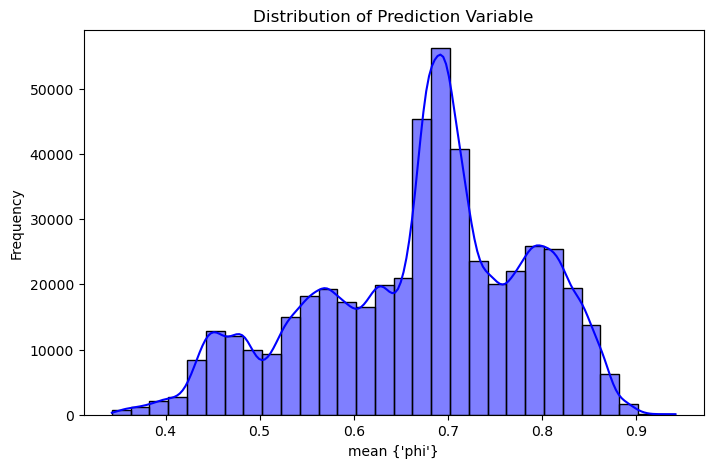

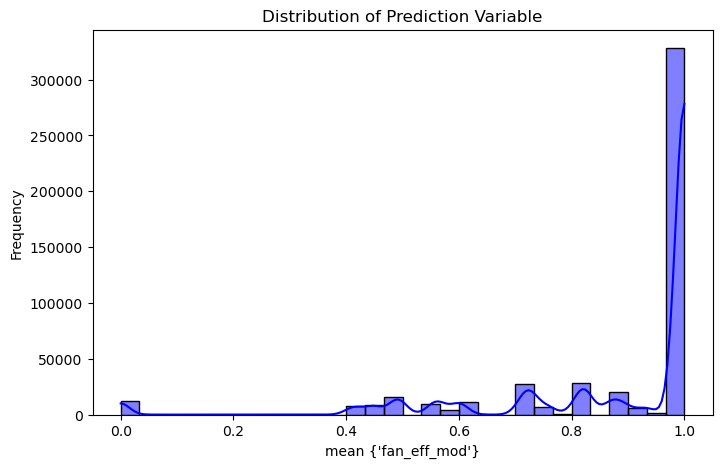

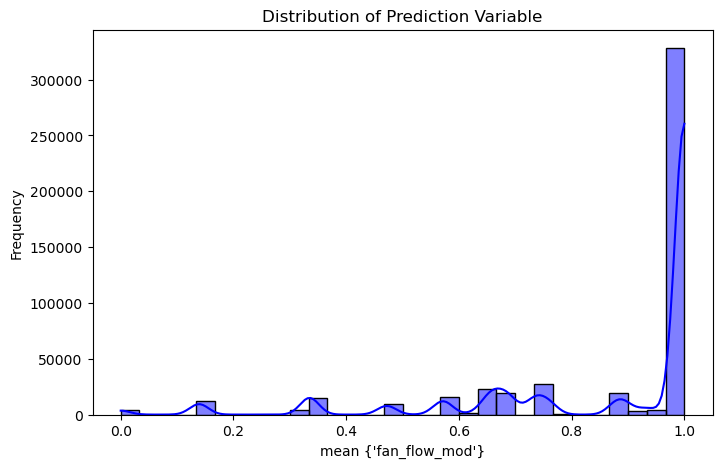

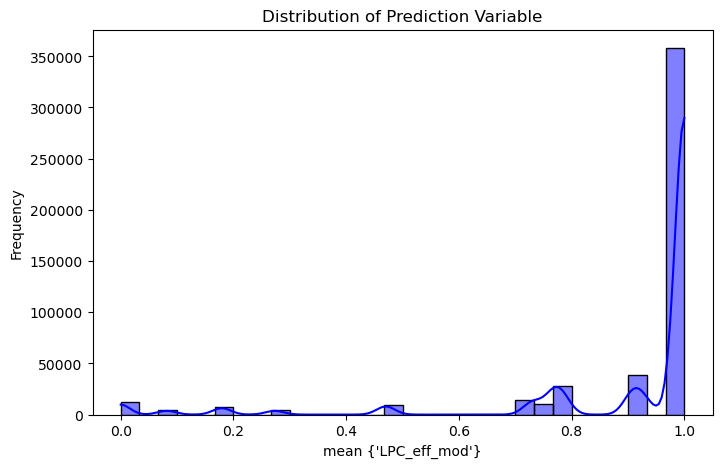

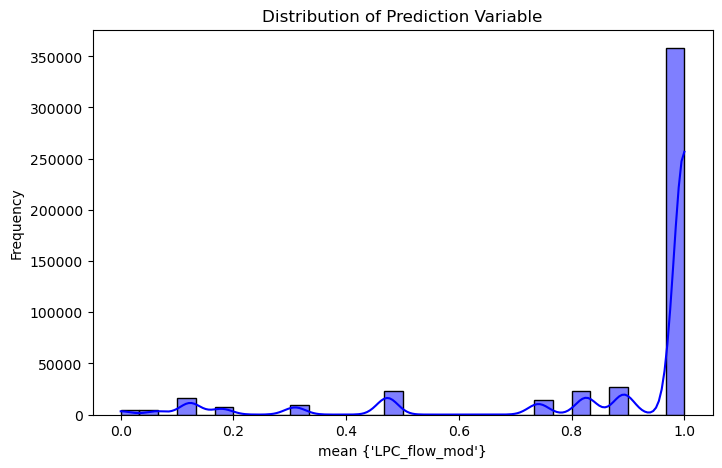

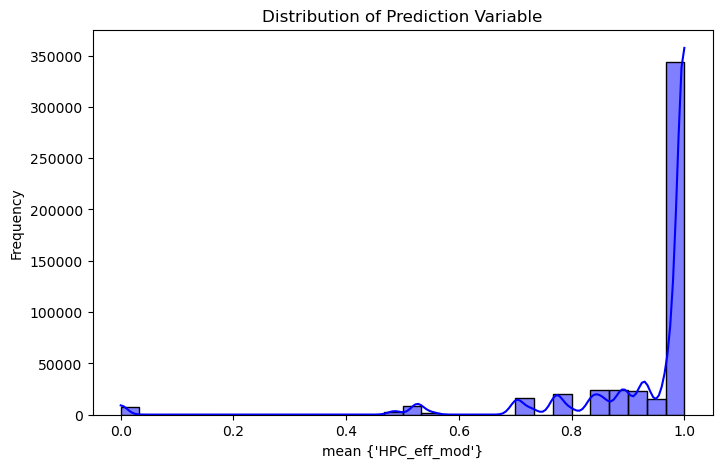

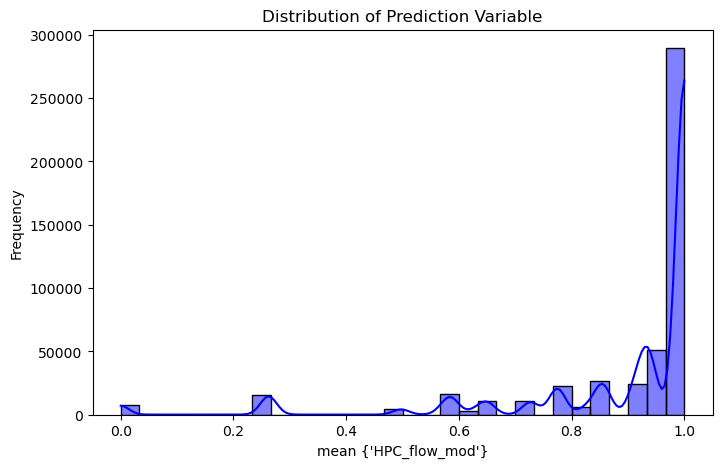

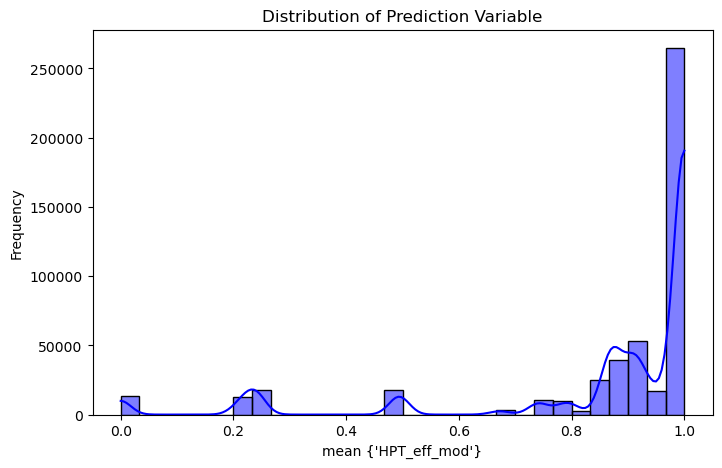

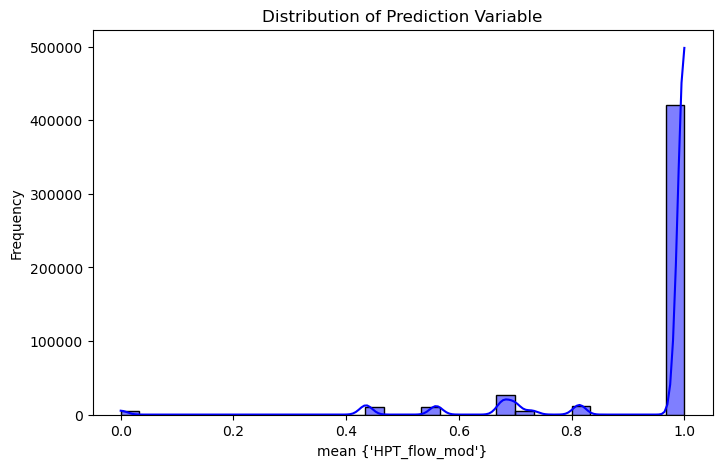

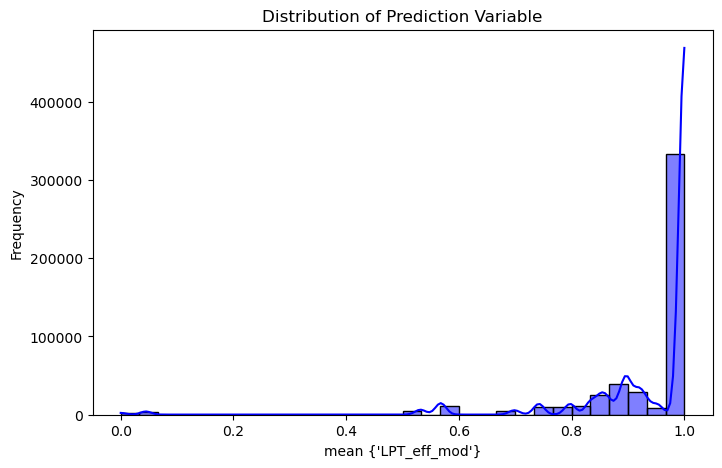

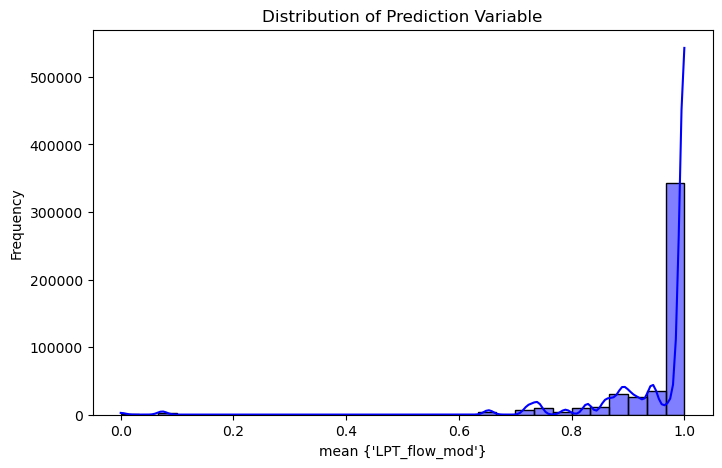

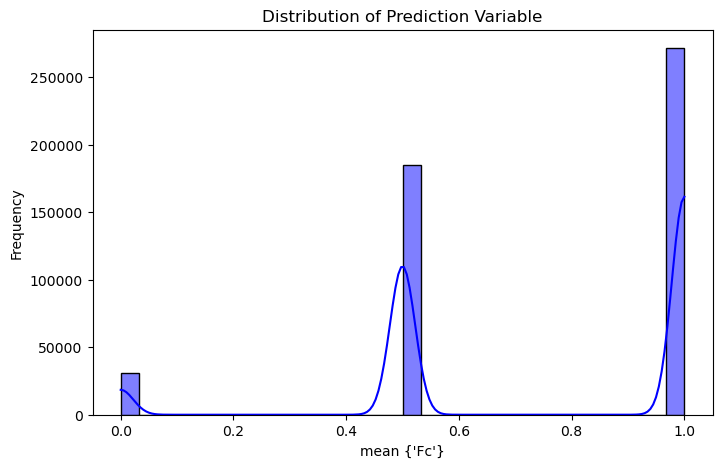

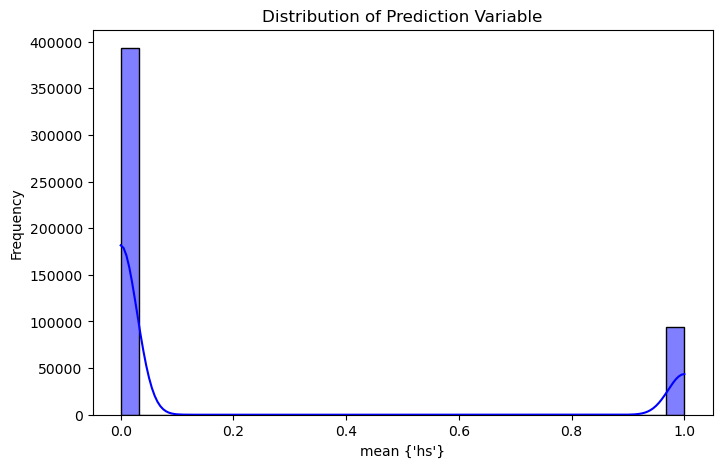

In [83]:
plot_mean_windows(feature_cols)

In [42]:
print('mean of prediction variable: ',  y.mean())
print('SD of prediction variable: ',  y.std())
print('Min of prediction variable: ',  y.min())
print('Max of prediction variable: ',  y.max())
print('Range of prediction variable: ',  y.max() - y.min())

mean of prediction variable:  34.189182
SD of prediction variable:  21.71993
Min of prediction variable:  0.0
Max of prediction variable:  92.0
Range of prediction variable:  92.0


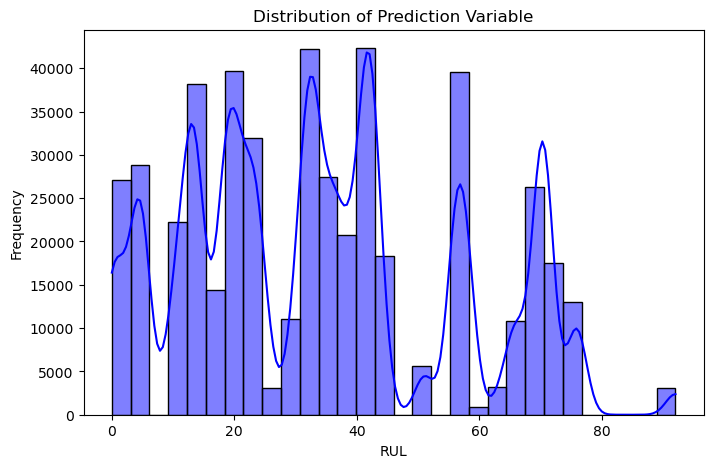

In [44]:
# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(y, bins=30, kde=True, color='blue', edgecolor='black')

# Labels and title
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Variable')

# Show plot
plt.show()


In [92]:
import numpy as np
from scipy.stats import linregress

# Function to compute slope across time steps for each feature
def compute_slope(arr):
    time_steps = np.arange(arr.shape[0])  
    return np.array([linregress(time_steps, arr[:, i]).slope for i in range(arr.shape[1])])

# Prepare an empty array to store slopes for all samples
slopes = np.zeros((X.shape[0], X.shape[2]))  

# Loop over each sample and compute slopes
for i in range(X.shape[0]):
    slopes[i] = compute_slope(X[i])

print("Slope Shape:", slopes.shape) 


KeyboardInterrupt



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram of slopes for the first feature as an example
sns.histplot(slopes[:, 0], bins=50, kde=True)  # Adjust the feature index as needed
plt.title('Distribution of Slopes for Feature 0')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Assuming 'target' is your target variable
correlations = np.corrcoef(slopes.T, target)
print("Correlations with target variable:", correlations[-1, :-1])  # Last row correlates with target